# Methods

## Prior knowledge preparation and utilizing

### Table 1

In [12]:
import pandas as pd
import numpy as np
from scipy import stats

# 计算95% CI和std
def calculate_stats(data):
    confidence = 0.95
    n = len(data)
    mean = np.mean(data)
    std = np.std(data)
    std_err = stats.sem(data)
    ci = stats.t.interval(confidence, n-1, mean, std_err)
    return round(mean, 3), round(std, 3), round(ci[0], 3), round(ci[1], 3)

# 对数值列计算统计量
df = pd.read_csv('ground_truth_train.csv')
numeric_columns = df.select_dtypes(include=[np.number]).columns
stats_results = {}

for col in numeric_columns:
    mean, std, ci_lower, ci_upper = calculate_stats(df[col].dropna())
    stats_results[col] = {
        'mean': mean,
        'std': std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

# 转换结果为DataFrame
stats_df = pd.DataFrame(stats_results).T
print("\nStatistical Summary:")
print(stats_df.head(5))


Statistical Summary:
              mean    std  ci_lower  ci_upper
Being-away   0.431  0.238     0.398     0.464
Coherence    0.430  0.221     0.399     0.461
Scope        0.421  0.237     0.388     0.454
Fascination  0.408  0.235     0.376     0.441
Average      0.423  0.178     0.398     0.447


d:\miniconda3\envs\torch\lib\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
d:\miniconda3\envs\torch\lib\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
import base64
import json
from openai import OpenAI
import time
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from threading import Semaphore

# 创建信号量限制并发请求
MAX_CONCURRENT_REQUESTS = 5  # 可以根据API限制调整这个值
semaphore = Semaphore(MAX_CONCURRENT_REQUESTS)

def vlm_evaluate(image_path):
    try:
        # 使用信号量控制并发
        with semaphore:
            with open(image_path, 'rb') as image_file:
                image_data = image_file.read()
                base64_image = base64.b64encode(image_data).decode('utf-8')
            
            client = OpenAI(
                api_key = "sk-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
                base_url = "https://api.zetatechs.com/v1/",
            )

            response = client.chat.completions.create(
                model='gpt-4o',
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", 
                             "text": "Please describe this street view image (limited 100words)."
                            },
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{base64_image}"
                                },
                            },
                        ],
                    }
                ],
            )

            response_text = response.choices[0].message.content.strip()
            return image_path, response_text
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return image_path, "Failed to get image description"

def process_single_image(row, idx, total):
    image = '.\\image\\' + row['image']
    print(f"Processing image {idx + 1}/{total}: {row['image']}")
    
    image_path, image_description = vlm_evaluate(image)
    
    text = f"This image could taken in {row['Time']}. {image_description} The restorative indicator scores are:\n" \
           f"- Being-away: {row['Being-away']:.5f}\n" \
           f"- Coherence: {row['Coherence']:.5f}\n" \
           f"- Scope: {row['Scope']:.5f}\n" \
           f"- Fascination: {row['Fascination']:.5f}\n" \
           f"- Average Score: {row['Average']:.5f}"
    
    return {'image_path': image, 'text': text}

def create_image_text_pairs(data):
    pairs = []
    total = len(data)
    
    # 创建线程池
    with ThreadPoolExecutor(max_workers=MAX_CONCURRENT_REQUESTS) as executor:
        # 提交所有任务
        future_to_row = {
            executor.submit(process_single_image, row, idx, total): idx 
            for idx, row in data.iterrows()
        }
        
        # 使用tqdm创建进度条
        with tqdm(total=total) as pbar:
            for future in as_completed(future_to_row):
                pair = future.result()
                pairs.append(pair)
                pbar.update(1)
    
    return pd.DataFrame(pairs)

# 读取CSV文件
df = pd.read_csv(r'D:\A_Research\C_complete_research\√20240522_seasonchange+SVI+campus\test_samples_all.csv')

# 获取图像文本对并转换为DataFrame
image_text_df = create_image_text_pairs(df)

# 保存到CSV文件
image_text_df.to_csv('image_text_pairs3.csv', index=False)

print("Image-text pairs have been saved to image_text_pairs.csv")

In [31]:
import pandas as pd

def create_image_text_pairs(data):
    pairs = []
    
    for _, row in data.iterrows():
        image = '.\\image\\' + row['image']
        
        text = f"This is an image could taken in {row['Time']}. The restorative indicator scores are:\n" \
               f"- Being-away: {row['Being-away']:.5f}\n" \
               f"- Coherence: {row['Coherence']:.5f}\n" \
               f"- Scope: {row['Scope']:.5f}\n" \
               f"- Fascination: {row['Fascination']:.5f}\n" \
               f"- Average Score: {row['Average']:.5f}"
        
        pairs.append({'image_path': image, 'text': text})
    
    return pd.DataFrame(pairs)

# Create DataFrame
df = pd.read_csv(r'D:\A_Research\C_complete_research\√20240522_seasonchange+SVI+campus\test_samples_all.csv')

# Get image-text pairs and convert to DataFrame
image_text_df = create_image_text_pairs(df)

# Save to CSV file
image_text_df.to_csv('image_text_pairs2.csv', index=False)

print("Image-text pairs have been saved to image_text_pairs.csv")

Image-text pairs have been saved to image_text_pairs.csv


## Multimodal embedding and retrieval. 

In [ ]:
import torch
from PIL import Image
import pandas as pd
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import os
from tqdm import tqdm

# 读取CSV文件
df = pd.read_csv('image_text_pairs3.csv')

# 加载CLIP模型和处理器
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def encode_image(image_path):
    try:
        image = Image.open(image_path)
        inputs = processor(images=image, return_tensors="pt", padding=True)
        image_features = model.get_image_features(**inputs)
        return image_features.detach().numpy()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def encode_text(text):
    try:
        inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True, max_length=77)
        text_features = model.get_text_features(**inputs)
        return text_features.detach().numpy()
    except Exception as e:
        print(f"Error processing text: {e}")
        return None

# 存储编码结果的字典
embeddings = {
    'image_embeddings': [],
    'text_embeddings': [],
    'image_paths': [],
    'texts': []
}

# 处理每一行数据
for idx, row in tqdm(df.iterrows()):
    image_path = row['image_path']
    text = row['text']
    
    # 编码图片
    img_embedding = encode_image(image_path)
    if img_embedding is not None:
        embeddings['image_embeddings'].append(img_embedding)
        embeddings['image_paths'].append(image_path)
    
    # 编码文本
    text_embedding = encode_text(text)
    if text_embedding is not None:
        embeddings['text_embeddings'].append(text_embedding)
        embeddings['texts'].append(text)

# 将编码结果转换为numpy数组并保存
embeddings['image_embeddings'] = np.array(embeddings['image_embeddings'])
embeddings['text_embeddings'] = np.array(embeddings['text_embeddings'])

# 保存编码结果
np.save('clip_embeddings3.npy', embeddings)

print("Embeddings have been saved successfully!")

d:\miniconda3\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
200it [00:41,  4.86it/s]

Embeddings have been saved successfully!


In [61]:
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
from typing import List, Tuple
import os

class CLIPRetriever:
    def __init__(self, embeddings_path: str):
        # 加载CLIP模型和处理器
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
        # 加载存储的embeddings
        self.stored_data = np.load(embeddings_path, allow_pickle=True).item()
        
        # 将存储的embeddings转换为张量
        self.image_embeddings = torch.tensor(self.stored_data['image_embeddings'].squeeze())
        self.texts = self.stored_data['texts']

    def encode_query_image(self, image_path: str) -> torch.Tensor:
        """编码查询图片"""
        image = Image.open(image_path)
        inputs = self.processor(images=image, return_tensors="pt", padding=True)
        image_features = self.model.get_image_features(**inputs)
        return image_features.detach()

    def compute_similarity(self, query_embedding: torch.Tensor) -> torch.Tensor:
        """计算余弦相似度"""
        # 标准化embeddings
        query_embedding = query_embedding.squeeze()
        query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)
        image_embeddings = self.image_embeddings / self.image_embeddings.norm(dim=-1, keepdim=True)
        
        # 计算相似度
        similarity = torch.matmul(query_embedding, image_embeddings.T)
        return similarity

    def retrieve(self, query_image_path: str, top_k: int = 5) -> List[Tuple[str, float]]:
        """检索最相似的文本"""
        # 编码查询图片
        query_embedding = self.encode_query_image(query_image_path)
        
        # 计算相似度
        similarities = self.compute_similarity(query_embedding)
        
        # 获取top-k结果
        top_k_values, top_k_indices = torch.topk(similarities, min(top_k, len(self.texts)))
        
        # 返回结果
        results = []
        for score, idx in zip(top_k_values.tolist(), top_k_indices.tolist()):
            results.append((self.texts[idx], score))
        
        return results

# 使用示例
def main():
    # 初始化检索器
    retriever = CLIPRetriever('clip_embeddings3.npy')
    
    # 查询图片路径
    query_image_path = "201708_120.2643098_31.48716696.png"
    
    # 获取检索结果
    results = retriever.retrieve(query_image_path, top_k=3)
    
    # 打印结果
    print(f"\nQuery Image: {query_image_path}")
    print("\nRetrieved Texts:")
    for text, score in results:
        print(f"\nSimilarity Score: {score:.4f}")
        print(f"Text: {text}")

if __name__ == "__main__":
    main()


Query Image: 201708_120.2643098_31.48716696.png

Retrieved Texts:

Similarity Score: 0.9093
Text: This image could taken in Summer. The image shows a peaceful street lined with lush green trees on both sides, creating a serene atmosphere. The road forks into two paths, with a landscaped garden in the center featuring trimmed bushes, grass, and decorative stone steps. A few cars are visible parked along the curved road on the right. Surrounding buildings with modern facades are partially visible, suggesting an institutional or corporate campus setting. Overcast skies add a soft light to the scene, enhancing the greenery's vividness. The view captures a clean, well-maintained environment designed for both aesthetics and functionality. The restorative indicator scores are:
- Being-away: 0.46437
- Coherence: 0.62569
- Scope: 0.32641
- Fascination: 0.16312
- Average Score: 0.39490

Similarity Score: 0.9072
Text: This image could taken in Summer. This street view shows a peaceful, tree-line

### Figure 2

d:\miniconda3\envs\torch\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\miniconda3\envs\torch\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "d:\miniconda3\envs\torch\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "d:\miniconda3\envs\torch\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\miniconda3\envs\torch\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


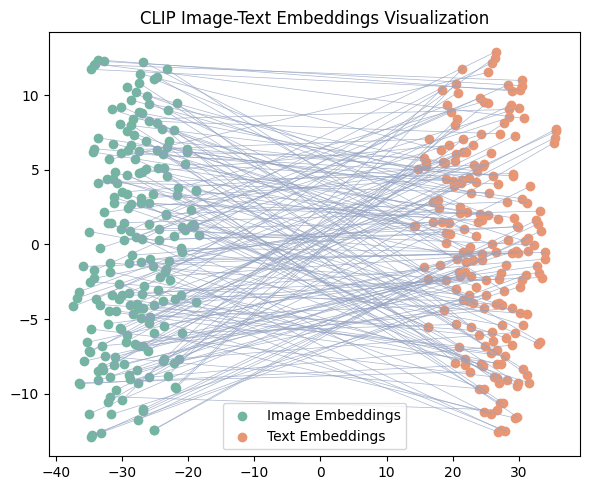

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 加载保存的embeddings
embeddings = np.load('clip_embeddings.npy', allow_pickle=True).item()

# 提取embeddings并reshape
image_embeddings = np.vstack([emb.reshape(1, -1) for emb in embeddings['image_embeddings']])
text_embeddings = np.vstack([emb.reshape(1, -1) for emb in embeddings['text_embeddings']])

# 合并图像和文本embeddings
combined_embeddings = np.vstack([image_embeddings, text_embeddings])

# 首先使用PCA降至50维
pca = PCA(n_components=50)
combined_embeddings_pca = pca.fit_transform(combined_embeddings)

# 然后使用t-SNE降至2维
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
combined_embeddings_tsne = tsne.fit_transform(combined_embeddings_pca)

# 分离图像和文本的降维结果
n_images = len(image_embeddings)
image_tsne = combined_embeddings_tsne[:n_images]
text_tsne = combined_embeddings_tsne[n_images:]

# 创建可视化
plt.figure(figsize=(6, 5))

# 绘制散点图
plt.scatter(image_tsne[:, 0], image_tsne[:, 1], 
           alpha=1, c='#74B5A1', label='Image Embeddings')
plt.scatter(text_tsne[:, 0], text_tsne[:, 1], 
           alpha=1, c='#E99674', label='Text Embeddings')

# 添加一些配对示例（前10对）
for i in range(len(image_tsne)):
    plt.plot([image_tsne[i, 0], text_tsne[i, 0]], 
             [image_tsne[i, 1], text_tsne[i, 1]], 
             '#94A3C2', alpha=0.8, linewidth=0.5)

plt.title('CLIP Image-Text Embeddings Visualization')
plt.legend()

plt.tight_layout()
plt.savefig('./figure/clip.jpg', dpi=300)
plt.show()

# Results

## Table 2

### our method

In [ ]:
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
from typing import List, Tuple
import os
import base64
import json
from openai import OpenAI
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd

class CLIPRetriever:
    def __init__(self, embeddings_path: str):
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.stored_data = np.load(embeddings_path, allow_pickle=True).item()
        self.image_embeddings = torch.tensor(self.stored_data['image_embeddings'].squeeze())
        self.texts = self.stored_data['texts']

    def encode_query_image(self, image_path: str) -> torch.Tensor:
        image = Image.open(image_path)
        inputs = self.processor(images=image, return_tensors="pt", padding=True)
        image_features = self.model.get_image_features(**inputs)
        return image_features.detach()

    def compute_similarity(self, query_embedding: torch.Tensor) -> torch.Tensor:
        query_embedding = query_embedding.squeeze()
        query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)
        image_embeddings = self.image_embeddings / self.image_embeddings.norm(dim=-1, keepdim=True)
        similarity = torch.matmul(query_embedding, image_embeddings.T)
        return similarity

    def retrieve(self, query_image_path: str, top_k: int = 5) -> List[Tuple[str, float]]:
        query_embedding = self.encode_query_image(query_image_path)
        similarities = self.compute_similarity(query_embedding)
        top_k_values, top_k_indices = torch.topk(similarities, min(top_k, len(self.texts)))
        results = []
        for score, idx in zip(top_k_values.tolist(), top_k_indices.tolist()):
            results.append((self.texts[idx], score))
        return results

class BatchImageEvaluator:
    def __init__(self, api_key: str, base_url: str, embeddings_path: str, max_workers: int = 4):
        self.client = OpenAI(api_key=api_key, base_url=base_url)
        self.retriever = CLIPRetriever(embeddings_path)
        self.max_workers = max_workers
        
    def process_single_image(self, image_path: str, message_template: str) -> dict:
        try:
            # Retrieve similar images
            results = self.retriever.retrieve(image_path, top_k=2)
            formatted_message = message_template.format(RAG="\n".join([text for text, score in results]))
            
            # Read and encode image
            with open(image_path, 'rb') as image_file:
                base64_image = base64.b64encode(image_file.read()).decode('utf-8')
            
            # Make API call
            response = self.client.chat.completions.create(
                model='gemini-2.5-flash-lite-preview-06-17-nothinking',
                # model='zeta/claude3-7-sonnet-20250219',
                messages=[{
                    "role": "user",
                    "content": [
                        {"type": "text", "text": formatted_message},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                    ]
                }]
            )
            
            response_text = response.choices[0].message.content.strip()
            
            # Parse response
            if response_text.startswith('```') and response_text.endswith('```'):
                response_text = response_text.strip('`')
            response_text = response_text.lstrip('json\n')
            result = json.loads(response_text)
            
            return {
                "image_path": image_path,
                "result": result,
                "status": "success"
            }
            
        except Exception as e:
            return {
                "image_path": image_path,
                "result": {"score": 0.0, "reason": str(e)},
                "status": "error"
            }

    def evaluate_batch(self, image_paths: List[str], message_template: str) -> List[dict]:
        results = []
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            future_to_image = {
                executor.submit(self.process_single_image, image_path, message_template): image_path 
                for image_path in image_paths
            }
            
            for future in tqdm(as_completed(future_to_image), total=len(image_paths)):
                result = future.result()
                results.append(result)
                
        return results

def save_results_to_csv(results: List[dict], output_path: str):
    """将结果保存到CSV文件"""
    data = []
    for result in results:
        row = {
            'image_path': result['image_path'],
            'status': result['status'],
            'score': result['result']['score']
        }
        # 添加每个维度的解释
        if 'reason' in result['result']:
            for dimension, explanation in result['result']['reason'].items():
                row[f'reason_{dimension}'] = explanation
        data.append(row)
    
    df = pd.DataFrame(data)
    df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")

def evaluate_metrics(predictions: List[dict], ground_truth_df: pd.DataFrame):
    """
    计算预测结果与ground truth之间的MSE、RMSE和R2分数
    
    Args:
        predictions: VLM输出的预测结果列表
        ground_truth_df: 包含真实值的DataFrame
    
    Returns:
        dict: 包含MSE、RMSE和R2分数的字典
    """
    # 提取预测值和真实值
    y_pred = []
    y_true = []
    
    for pred in predictions:
        image_path = pred['image_path']
        # 获取对应的ground truth行
        gt_row = ground_truth_df[ground_truth_df['image'] == image_path]
        
        if not gt_row.empty:
            y_pred.append(pred['result']['score'])
            y_true.append(gt_row['Average'].iloc[0])
    
    # 转换为numpy数组
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    # 计算指标
    mse = np.mean((y_pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    
    # 计算R2分数
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

if __name__ == "__main__":
    # 配置参数
    api_key = "sk-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
    base_url = "https://api.zetatechs.com/v1/"

    embeddings_path = "clip_embeddings3.npy"
    
    # 读取包含图片路径的CSV文件
    df = pd.read_csv('ground_truth_test.csv', encoding='gbk')  # 替换为你的CSV文件路径
    image_paths = df['image'].tolist()  # 假设列名为'image_path'
    
    # 初始化评估器
    evaluator = BatchImageEvaluator(api_key, base_url, embeddings_path)
    
    # 定义消息模板
    message_template = '''
    You are a university student participating in a campus environment assessment. Carefully analyze the provided image to evaluate psychological restoration quality. Provide step-by-step reasoning before final scoring.

    Evaluate the space using Perceived Restorativeness Scale (PRS)-11 (0-1 scale) across four dimensions. **1 = Strongly agree, 0 = Strongly disagree**. Base all judgments strictly on image features and prior knowledge 

    Prior Knowledge:\n{RAG}.

    Evaluation Dimensions:
    1. Fascination
    - Places like that are fascinating
    - In places like this my attention is drawn to many interesting things
    - In places like this it is hard to be bored
    2. Being Away
    - Places like that are a refuge fom nuisances
    - To get away from things that usually demand my attention I like to go to places like this 
    - To stop thinking about the things that I must get done I like to go to places like this
    3. Coherence
    - There is a clear order in the physical arrangement of places like this
    - In places like this it is easy to see how things are organised
    - In places like this everything seems to have its proper place
    4. Scope
    - That place is large enough to allow exploration in many directions
    - In places like that there are few boundaries to limit my possibility for moving about

    Please provide follow information ONLY:
    1. Average score of all dimension (Scale 0-1 with 5 decimal places)
    2. Explanation for each PRS dimension (limited to 200 words)

    You MUST output JSON format ONLY:
    ```json
    {{
       "score": 0.75, 
       "reason": {{
          "fascination": XXX,
          "being_away": XXX,
          "coherence": XXX,
          "scope": XXX,
       }}
    }}
    '''
    
    # 处理图片批次
    results = evaluator.evaluate_batch(image_paths, message_template)
    
    # 保存结果到CSV
    save_results_to_csv(results, './result_data/evaluation_results_claude37_k5.csv')

    # 计算评估指标
    metrics = evaluate_metrics(results, df)
    print("\nValidation Metrics:")
    print(f"MSE: {metrics['MSE']:.5f}")
    print(f"RMSE: {metrics['RMSE']:.5f}")
    print(f"R2: {metrics['R2']:.5f}")
    
    # 打印结果
    for result in results:
        print(f"\nImage: {result['image_path']}")
        print(f"Status: {result['status']}")
        print(f"Score: {result['result']['score']}")
        print("Reasons:")
        for dimension, explanation in result['result']['reason'].items():
            print(f"- {dimension}: {explanation[:100]}...")

d:\miniconda3\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Results saved to ./result_data/evaluation_results_claude37_k5.csv

Validation Metrics:
MSE: 0.01566
RMSE: 0.12515
R2: 0.54440

Image: .\image\201603_120.2703794_31.47882788.png
Status: success
Score: 0.28869
Reasons:
- fascination: The scene offers some visual interest with the mix of trees, buildings, and parked vehicles, but lac...
- being_away: While the environment is an urban setting, the presence of parked vehicles, roads, and commercial bu...
- coherence: The arrangement of buildings and pathways is generally orderly, with clear separations between vehic...
- scope: The visible area is a street with adjacent landscaped sections and buildings. While there are pathwa...

Image: .\image\201603_120.270227_31.48739147.png
Status: success
Score: 0.71297
Reasons:
- fascination: The scene offers a variety of natural elements like trees and green spaces, interspersed with modern...
- being_away: The presence of trees, grassy areas, and a curved pathway creates a sense of separation from 

### traditional method

In [123]:
import pandas as pd
df = pd.read_csv('ground_truth_train.csv')

# 假设CSV文件中最后一列是因变量，其余列是自变量
y = df.iloc[:, 6]  # 自变量
X = df.iloc[:, 7:]   # 因变量

In [144]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True)

# 通用参数设置
n_estimators = 100
learning_rate = 0.01
max_depth = 15
subsample = 0.8
random_state = 50
reg_alpha = 0.1  # L1正则化
reg_lambda = 0.1  # L2正则化

# LightGBM
lgb_reg = lgb.LGBMRegressor(objective="regression",
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            subsample=subsample,
                            colsample_bytree=0.8,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            verbose=-1,
                            random_state=random_state)

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=n_estimators,
                              max_depth=max_depth,
                              max_samples=subsample,  # 类似于subsample
                              random_state=random_state)

# Decision Tree
dt_reg = DecisionTreeRegressor(criterion='squared_error',
                              max_depth=max_depth,
                              random_state=random_state,
                              min_samples_split=2,
                              min_samples_leaf=10,
                              splitter='best')

# GBDT
gbdt_reg = GradientBoostingRegressor(n_estimators=n_estimators,
                                    learning_rate=learning_rate,
                                    max_depth=max_depth,
                                    subsample=subsample,
                                    random_state=random_state)

# KNN (无法完全匹配其他模型的参数，保持原样)
knn_reg = KNeighborsRegressor(n_neighbors=5)

# XGBoost
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror",
                           learning_rate=learning_rate,
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           subsample=subsample,
                           colsample_bytree=0.8,
                           reg_alpha=reg_alpha,
                           reg_lambda=reg_lambda,
                           tree_method='hist',
                           enable_categorical=True,
                           random_state=random_state)

# Linear Regression (参数较少，保持原样)
lr_reg = LinearRegression(n_jobs=10,
                         positive=True)

models = [
    # lgb_reg, 
    rf_reg, 
    dt_reg, 
    gbdt_reg, 
    knn_reg, 
    # xgb_reg, 
    lr_reg]

rm = []
rr = []
me = []

for model in models:
    # 使用5折交叉验证
    rmse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    mse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    # mape = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
    r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    rm.append(np.mean(np.sqrt(-rmse)))
    me.append(np.mean(np.sqrt(-mse)))
    rr.append(np.mean(r2))

    print('Model:', type(model).__name__)
    print('RMSE:', np.mean(np.sqrt(-rmse)))
    print('MSE:', np.mean(np.sqrt(-mse)))
    print('R^2 Score:', np.mean(r2))
    print()

Model: RandomForestRegressor
RMSE: 0.38436367635113317
MSE: 0.14822703358103542
R^2 Score: 0.27562074540000686

Model: DecisionTreeRegressor
RMSE: 0.4162005759095145
MSE: 0.1737576502030955
R^2 Score: 0.008659328173720171

Model: GradientBoostingRegressor
RMSE: 0.39239453293500504
MSE: 0.154394036996825
R^2 Score: 0.22046860936638013

Model: KNeighborsRegressor
RMSE: 0.4164430074756769
MSE: 0.17357420936164575
R^2 Score: 0.01208584335668823

Model: LinearRegression
RMSE: 0.4088330155631124
MSE: 0.16740833050303552
R^2 Score: 0.07020702207847802



## Figure 3

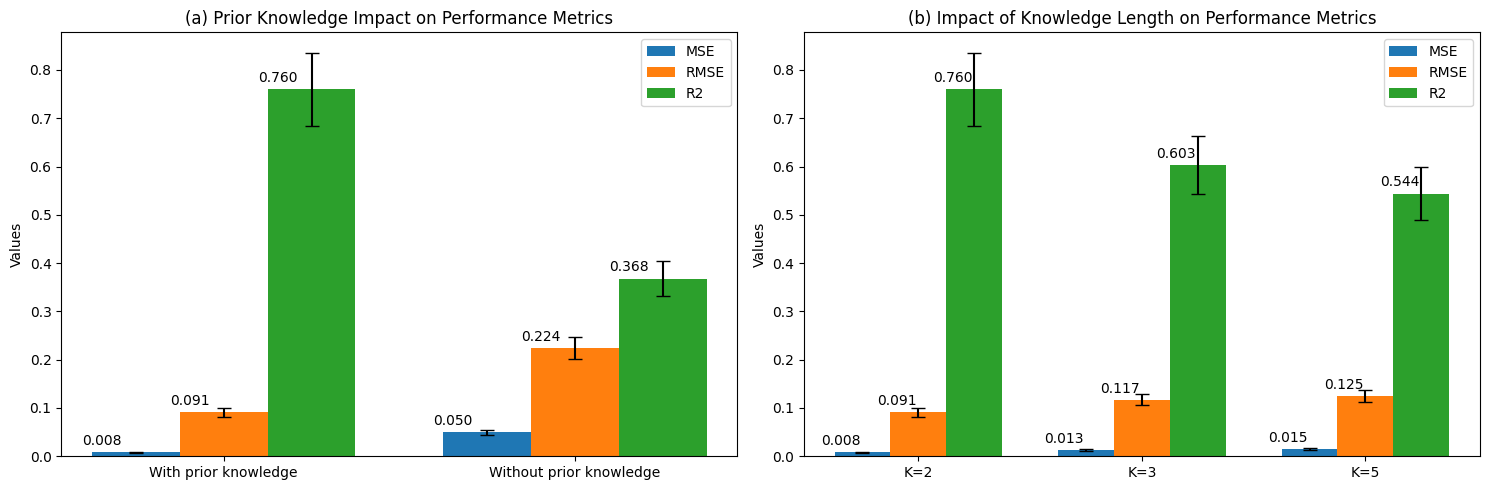

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 创建第一个数据框
data1 = {
    'Method': ['With prior knowledge', 'Without prior knowledge'],
    'MSE': [0.008, 0.05],
    'RMSE': [0.091, 0.224],
    'R2': [0.760, 0.368]
}
df1 = pd.DataFrame(data1)

# 创建第二个数据框
data2 = {
    'Knowledge Length': ['K=2', 'K=3', 'K=5'],
    'MSE': [0.008, 0.013, 0.015],
    'RMSE': [0.091, 0.117, 0.125],
    'R2': [0.76, 0.603, 0.544]
}
df2 = pd.DataFrame(data2)

# 计算误差（假设为值的10%）
error1 = {
    'MSE': df1['MSE'] * 0.1,
    'RMSE': df1['RMSE'] * 0.1,
    'R2': df1['R2'] * 0.1
}

error2 = {
    'MSE': df2['MSE'] * 0.1,
    'RMSE': df2['RMSE'] * 0.1,
    'R2': df2['R2'] * 0.1
}

# 设置图表风格
# plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 绘制第一个图 (对比不同方法)
x = np.arange(len(df1['Method']))
width = 0.25

# 绘制柱状图和误差棒
bars1 = ax1.bar(x - width, df1['MSE'], width, label='MSE', yerr=error1['MSE'], capsize=5)
bars2 = ax1.bar(x, df1['RMSE'], width, label='RMSE', yerr=error1['RMSE'], capsize=5)
bars3 = ax1.bar(x + width, df1['R2'], width, label='R2', yerr=error1['R2'], capsize=5)

# 添加数值标签
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 9, height),
                    xytext=(0, 3),  # 3点垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1, ax1)
autolabel(bars2, ax1)
autolabel(bars3, ax1)

ax1.set_ylabel('Values')
ax1.set_title('(a) Prior Knowledge Impact on Performance Metrics')
ax1.set_xticks(x)
ax1.set_xticklabels(df1['Method'])
ax1.legend()

# 绘制第二个图 (不同Knowledge Length的比较)
x = np.arange(len(df2['Knowledge Length']))
width = 0.25

# 绘制柱状图和误差棒
bars1 = ax2.bar(x - width, df2['MSE'], width, label='MSE', yerr=error2['MSE'], capsize=5)
bars2 = ax2.bar(x, df2['RMSE'], width, label='RMSE', yerr=error2['RMSE'], capsize=5)
bars3 = ax2.bar(x + width, df2['R2'], width, label='R2', yerr=error2['R2'], capsize=5)

# 添加数值标签
autolabel(bars1, ax2)
autolabel(bars2, ax2)
autolabel(bars3, ax2)

ax2.set_ylabel('Values')
ax2.set_title('(b) Impact of Knowledge Length on Performance Metrics')
ax2.set_xticks(x)
ax2.set_xticklabels(df2['Knowledge Length'])
ax2.legend()

# 调整布局
plt.tight_layout()
plt.savefig('./figure/performance_metrics_comparison.jpg', dpi=300)
plt.show()

## Figure 4

In [29]:
import pandas as pd
import numpy as np

try:
    # 读取CSV数据
    df = pd.read_csv('./result_data/evaluation_results_claude37_all.csv', encoding='ISO-8859-1')
    
    # 提取score列并转换为numpy数组
    scores = df['score'].values
    
    # 计算 25% 和 75% 分位
    low_th  = np.percentile(scores, 5)   # ≤ 25% → Low
    high_th = np.percentile(scores, 95)   # ≥ 75% → High

    breaks = [scores.min(), low_th, high_th, scores.max()]

    def get_quality_class(score):
        if score <= low_th:
            return 'Low quality'
        elif score >= high_th:
            return 'High quality'
        else:
            return 'Medium quality'

    df['quality_class'] = df['score'].apply(get_quality_class)

    # 打印断点值和每个类别的数量
    print("Break points:", breaks)
    print("\nClass distribution:")
    print(df['quality_class'].value_counts())
    print("\nBreak points details:")
    print(f"Low quality: <= {breaks[1]}")
    print(f"Medium quality: {breaks[1]} - {breaks[2]}")
    print(f"High quality: > {breaks[2]}")

    # 保存结果到新的CSV文件
    df.to_csv('./result_data/classified_data2.csv', index=False, encoding='utf-8')
    
except Exception as e:
    print(f"发生错误: {str(e)}")

Break points: [0.1169, 0.257236, 0.675, 0.8]

Class distribution:
Medium quality    838
High quality       48
Low quality        47
Name: quality_class, dtype: int64

Break points details:
Low quality: <= 0.257236
Medium quality: 0.257236 - 0.675
High quality: > 0.675


       quality_class Features (Top5)  Value
0     Medium quality            road   0.28
1     Medium quality            road   0.27
2     Medium quality            road   0.21
3     Medium quality            road   0.32
4     Medium quality            road   0.36
...              ...             ...    ...
4660  Medium quality             sky   0.36
4661  Medium quality             sky   0.16
4662  Medium quality             sky   0.19
4663  Medium quality             sky   0.38
4664  Medium quality             sky   0.38

[4347 rows x 3 columns]


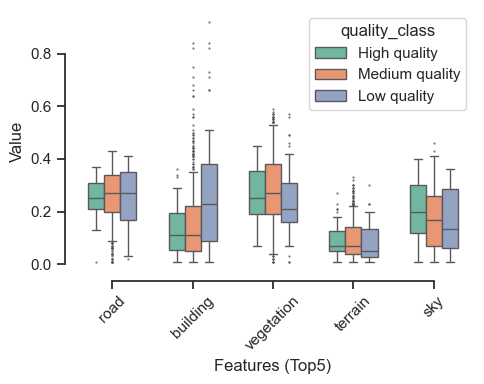

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="Set2")

df_wide = pd.read_csv("./result_data/classified_data2.csv")
# 载入数据到DataFrame
# df_wide = pd.DataFrame(tips)

# 将宽格式DataFrame转换为长格式DataFrame
df_long = df_wide.iloc[:,9:].melt(id_vars=['quality_class'], var_name='Features (Top5)', value_name='Value')
df_long = df_long[df_long['Value'] != 0]
print(df_long)

# Load the example tips dataset
# tips = sns.load_dataset("tips")
plt.subplots(figsize = (5, 4))

order = ['High quality', 'Medium quality', 'Low quality']
df_long['quality_class'] = pd.Categorical(df_long['quality_class'], categories=order, ordered=True)

# Draw a nested boxplot to show bills by day and time
# ax = sns.boxplot(x="Variable", y="Value",
#             hue="quality_class", 
#             # palette=["m", "g"],
#             data=df_long)

ax = sns.boxplot(x="Features (Top5)", y="Value",
            hue="quality_class", 
            data=df_long,
            # palette=["m", "g"],
            width=0.6,
            whis=0.8,
            fliersize=0.5,
            )

sns.despine(offset=5, trim=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# 调整布局
plt.tight_layout()
plt.savefig('./figure/box.jpg', dpi=300)
plt.show()

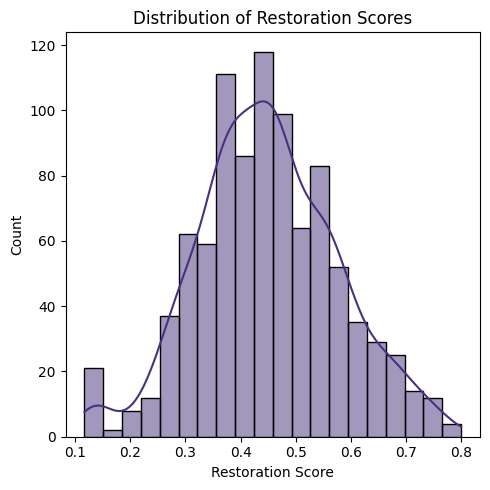

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# Set style for academic figures
# plt.style.use('seaborn-whitegrid')
sns.set_palette("viridis")

# Load your data
df = pd.read_csv('./result_data/classified_data.csv')  # Replace with your actual file path

plt.figure(figsize=(5, 5))
sns.histplot(data=df, x='score', bins=20, kde=True)
plt.xlabel('Restoration Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Distribution of Restoration Scores', fontsize=12)
plt.tight_layout()
plt.savefig('./figure/score_distribution.png', bbox_inches='tight', dpi=300)
# plt.close()

## Figure 5

### extract triple

In [ ]:
import os
import pandas as pd
import json
from openai import OpenAI
from tqdm import tqdm
import re
import concurrent.futures
tqdm.pandas()  # 启用 pandas 的进度条扩展

# Configure API
api_key = "sk-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
base_url = "https://api.zetatechs.com/v1/"

client = OpenAI(api_key=api_key, base_url=base_url)

# Define analysis prompts
prompts = {
    "reason_fascination": """
    Analyze the text about Fascination of restorative quality of campus spaces. 
    Extract TRIPLETS following the "Spatial Elements → Psychological Perception → Behavioral Motivation" framework:

    "{text}"

    Extraction rules:
    1. Spatial Elements: Physical objects (e.g., plants, buildings, water features) (one word)
    2. Psychological Perception: Resulting mental states (short phrase)
    3. Behavioral Motivation: Actions triggered (short phrase)
    4. Relation Type: positive/negative/neutral based on effect

    Return EXACTLY this JSON format:
    {{
        "chains": [
            {{
                "spatial_element": "element1 (one word)",
                "psychological_perception": "perception1",
                "behavioral_motivation": "motivation1",
                "relation_type": "positive/negative/neutral"
            }},
            {{
                "spatial_element": "element2",
                ...
            }}
        ]
    }}
    """,
    
    "reason_being_away": """
    Please analyze the following text about Being Away of restorative quality of campus spaces based on PRS-11 questionnaire.
    Extract entities based on the "Spatial Elements → Psychological Perception → Behavioral Motivation" framework:
    
    "{text}"
    
    Extraction rules:
    1. Spatial Elements: Physical objects (e.g., plants, buildings, water features) (one word)
    2. Psychological Perception: Resulting mental states (short phrase)
    3. Behavioral Motivation: Actions triggered (short phrase)
    4. Relation Type: positive/negative/neutral based on effect

    Return EXACTLY this JSON format:
    {{
        "chains": [
            {{
                "spatial_element": "element1 (one word)",
                "psychological_perception": "perception1",
                "behavioral_motivation": "motivation1",
                "relation_type": "positive/negative/neutral"
            }},
            {{
                "spatial_element": "element2",
                ...
            }}
        ]
    }}
    """,
    
    "reason_coherence": """
    Please analyze the following text about Coherence of restorative quality of campus spaces based on PRS-11 questionnaire.
    Extract entities based on the "Spatial Elements → Psychological Perception → Behavioral Motivation" framework:
    
    "{text}"
    
    Extraction rules:
    1. Spatial Elements: Physical objects (e.g., plants, buildings, water features) (one word)
    2. Psychological Perception: Resulting mental states (short phrase)
    3. Behavioral Motivation: Actions triggered (short phrase)
    4. Relation Type: positive/negative/neutral based on effect

    Return EXACTLY this JSON format:
    {{
        "chains": [
            {{
                "spatial_element": "element1 (one word)",
                "psychological_perception": "perception1",
                "behavioral_motivation": "motivation1",
                "relation_type": "positive/negative/neutral"
            }},
            {{
                "spatial_element": "element2",
                ...
            }}
        ]
    }}
    """,
    
    "reason_scope": """
    Please analyze the following text about Scope of restorative quality of campus spaces based on PRS-11 questionnaire.
    Extract entities based on the "Spatial Elements → Psychological Perception → Behavioral Motivation" framework:
    
    "{text}"
    
    Extraction rules:
    1. Spatial Elements: Physical objects (e.g., plants, buildings, water features) (one word)
    2. Psychological Perception: Resulting mental states (short phrase)
    3. Behavioral Motivation: Actions triggered (short phrase)
    4. Relation Type: positive/negative/neutral based on effect

    Return EXACTLY this JSON format:
    {{
        "chains": [
            {{
                "spatial_element": "element1 (one word)",
                "psychological_perception": "perception1",
                "behavioral_motivation": "motivation1",
                "relation_type": "positive/negative/neutral"
            }},
            {{
                "spatial_element": "element2",
                ...
            }}
        ]
    }}
    """,
}

def analyze_text(text, analysis_type):
    """使用LLM分析文本并返回三元组链"""
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a structured data extraction assistant. Return ONLY valid JSON."},
                {"role": "user", "content": prompts[analysis_type].format(text=text)}
            ],
            response_format={"type": "json_object"},
            temperature=0.3  # 降低随机性
        )
        result = json.loads(response.choices[0].message.content)
        return result.get("chains", [])
    except Exception as e:
        print(f"分析错误: {e}")
        return []

def process_single_text(args):
    """处理单个文本的包装函数，用于并行执行"""
    idx, row, analysis_type = args
    text = row[analysis_type]
    image_id = os.path.basename(row["image_path"])
    chains = analyze_text(text, analysis_type)
    return [dict(chain, image_id=image_id) for chain in chains]

def main():
    # Create output directory
    output_dir = "spatial_analysis_results"
    os.makedirs(output_dir, exist_ok=True)
    
    # Read CSV data
    df = pd.read_csv('./result_data/classified_data2.csv', encoding='gbk')
    
    # 设置并行工作线程数 (根据API限制调整)
    MAX_WORKERS = 10
    
    # Process each analysis type
    analysis_types = ["reason_fascination", "reason_being_away", "reason_coherence", "reason_scope"]
    
    for analysis_type in analysis_types:
        print(f"Processing {analysis_type}...")
        all_chains = []
        
        # 准备并行任务参数
        tasks = [(idx, row, analysis_type) for idx, row in df.iterrows()]
        
        # 使用线程池并行处理文本
        with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            # 使用tqdm显示进度条
            results = list(tqdm(executor.map(process_single_text, tasks), total=len(tasks)))
        
        # 收集所有结果
        for result in results:
            all_chains.extend(result)
        
        if all_chains:
            chain_df = pd.DataFrame(all_chains)
            
            output_path = os.path.join(output_dir, f"{analysis_type}_relationships_3.csv")
            chain_df.to_csv(output_path, index=False)
            print(f"Saved {len(chain_df)} chains to {output_path}")

    print("All analyses completed. Final results saved.")

if __name__ == "__main__":
    main()

Processing reason_fascination...


100%|██████████| 933/933 [05:13<00:00,  2.98it/s]


Saved 3666 chains to spatial_analysis_results\reason_fascination_relationships_3.csv
Processing reason_being_away...


100%|██████████| 933/933 [04:49<00:00,  3.22it/s]


Saved 3238 chains to spatial_analysis_results\reason_being_away_relationships_3.csv
Processing reason_coherence...


100%|██████████| 933/933 [05:47<00:00,  2.69it/s]


Saved 3952 chains to spatial_analysis_results\reason_coherence_relationships_3.csv
Processing reason_scope...


100%|██████████| 933/933 [06:00<00:00,  2.59it/s]


Saved 3508 chains to spatial_analysis_results\reason_scope_relationships_3.csv
All analyses completed. Final results saved.


### merge the same word

In [ ]:
import pandas as pd
from collections import defaultdict
import numpy as np

import os
import pandas as pd
import json
from openai import OpenAI
from tqdm import tqdm
import re
import concurrent.futures
tqdm.pandas()  # 启用 pandas 的进度条扩展

# 设置OpenAI API key
api_key = "sk-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
base_url = "https://api.zetatechs.com/v1/"

client = OpenAI(api_key=api_key, base_url=base_url)

def get_similar_meanings(texts, column_name):
    """使用GPT模型找出语义相似的表达并给出标准表达"""
    
    texts = [str(t) for t in texts if pd.notna(t)]

    prompt = f"""Below are several different expressions from the {column_name} column. 
    Please identify groups of similar meanings and provide one standard expression for each group.
    Especially for 'engagement', please ensure the standardized text is concise and clear.
    Only output the mapping in the format: original_text -> standardized_text
    
    Expressions:
    {', '.join(texts)}
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}]
        )
        
        # 解析返回的映射关系
        mappings = {}
        for line in response.choices[0].message.content.strip().split('\n'):
            if '->' in line:
                original, standard = line.split('->')
                mappings[original.strip()] = standard.strip()
        
        return mappings
    
    except Exception as e:
        print(f"Error in API call: {e}")
        return {}

def standardize_column(df, column_name):
    """标准化指定列中的相似表达"""
    
    # 获取唯一值
    unique_values = df[column_name].unique().tolist()
    
    # 获取标准化映射
    standardization_map = get_similar_meanings(unique_values, column_name)
    
    # 应用映射到数据框
    df[f'{column_name}_standardized'] = df[column_name].map(
        lambda x: standardization_map.get(x, x)
    )
    
    return df

# 读取CSV文件
df = pd.read_csv('./spatial_analysis_results/reason_scope_relationships_3.csv')

# 对behavioral_motivation列进行标准化
df = standardize_column(df, 'behavioral_motivation')

# 显示结果
print("Original vs Standardized behavioral_motivation:")
comparison = pd.DataFrame({
    'Original': df['behavioral_motivation'],
    'Standardized': df['behavioral_motivation_standardized']
}).drop_duplicates()
print(comparison)

# 保存结果
df.to_csv('./spatial_analysis_results/standardized_output_scope.csv', index=False)

Original vs Standardized behavioral_motivation:
                            Original                    Standardized
0           movement and exploration                     exploration
4                reduced exploration             limited exploration
5              discouraged wandering          discourage exploration
6                restricted movement                 limits movement
7                        exploration                     exploration
...                              ...                             ...
3478  suggesting further exploration  suggesting further exploration
3479        limiting expansive views        limiting expansive views
3480               offering movement               offering movement
3481           allowing for movement           allowing for movement
3492               avoidance of area               avoidance of area

[784 rows x 2 columns]


### visual the network

nodes: 20
edges: 88
density: 0.23157894736842105
avg_degree: 8.8
top_nodes_by_degree: [('buildings', 10), ('limited exploration', 10), ('limits movement', 10), ('pathways', 10), ('road', 10), ('roads', 10), ('trees', 10), ('exploration', 9), ('hesitant exploration', 9), ('promotes exploration', 9)]

Edge type ratios:
positive: 44.3%
negative: 51.1%
neutral: 4.5%


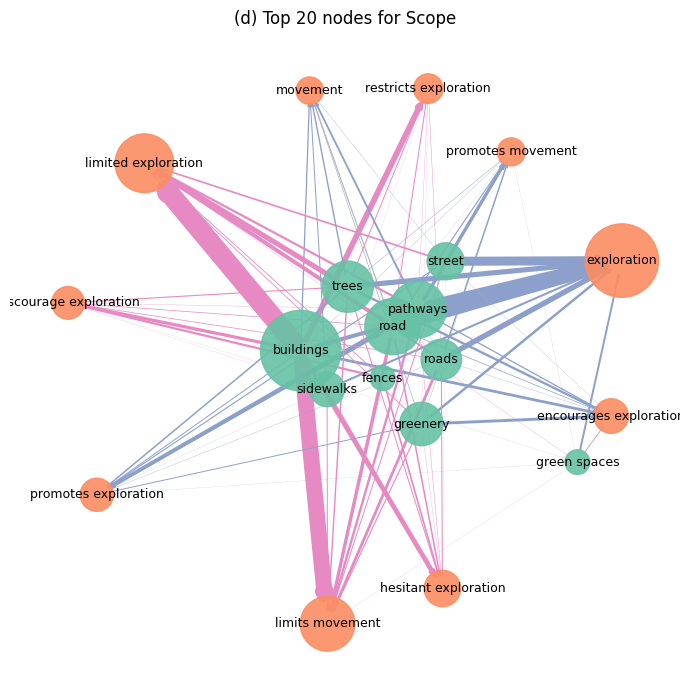

In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ======== 1. 读取数据 ========
df = pd.read_csv("./spatial_analysis_results/standardized_output_scope.csv")
# df = df[df['relation_type']== 'negative']  # 只保留正向关系
# df = df[df['behavioral_motivation_standardized']!= 'none']  # 只保留正向关系

spatial = 'spatial_element'
perception = 'psychological_perception'
motivation = 'behavioral_motivation_standardized'

# ======== 2. 统计 element 和 perception 频率 ========
element_counts = df[spatial].value_counts().reset_index()
element_counts.columns = ["node", "count"]

behavioral_counts = df[motivation].value_counts().reset_index()
behavioral_counts.columns = ["node", "count"]

# ======== 3. 取前 10 个 element & perception 节点 ========
top_elements = element_counts.head(10)["node"]
top_behavioral = behavioral_counts.head(10)["node"]

# 只保留这些 element & perception 对应的链路
df = df[df[spatial].isin(top_elements) & df[motivation].isin(top_behavioral)]

# ======== 4. 构建节点频率字典（element + perception） ========
freq_dict = pd.concat([element_counts, behavioral_counts], ignore_index=True) \
              .groupby("node")["count"].sum().to_dict()

# ======== 5. 边频率统计 ========
edge_freq = df.groupby([spatial, motivation]).size().to_dict()

## behavioral_motivation, psychological_perception
# ======== 6. 建立有向图，并保存 relation_type & 频率 ========
G = nx.DiGraph()
for (u, v), freq in edge_freq.items():
    relation_type = df[(df[spatial] == u) & (df[motivation] == v)]["relation_type"].iloc[0]
    psychological_perception = df[(df[spatial] == u) & (df[motivation] == v)][perception].iloc[0]
    G.add_edge(u, v, label=psychological_perception, relation=relation_type, weight=freq)

def analyze_graph(G):
    # 基本网络指标
    analysis = {
        'nodes': len(G.nodes()),
        'edges': len(G.edges()),
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / len(G),
        'top_nodes_by_degree': sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
    }
    
    # 统计边的关系类型比例
    edge_types = {'positive': 0, 'negative': 0, 'neutral': 0}
    total_edges = len(G.edges())
    
    for u, v, data in G.edges(data=True):
        relation = data['relation']
        if relation in edge_types:
            edge_types[relation] += 1
            
    # 计算比例
    edge_type_ratios = {k: v/total_edges for k, v in edge_types.items()}
    analysis['edge_type_ratios'] = edge_type_ratios
    
    return analysis

analysis = analyze_graph(G)
for metric, value in analysis.items():
    if metric == 'edge_type_ratios':
        print("\nEdge type ratios:")
        for type_name, ratio in value.items():
            print(f"{type_name}: {ratio:.1%}")
    else:
        print(f"{metric}: {value}")

# ======== 7. 手动左右布局 ========
elements = sorted(top_elements, key=lambda x: freq_dict.get(x, 0), reverse=True)
behavioral = sorted(top_behavioral, key=lambda x: freq_dict.get(x, 0), reverse=True)

pos = nx.spring_layout(G, k=5, iterations=100, seed=123)  # 使用 spring 布局

# ======== 8. 节点大小（频率 * 缩放系数） ========
node_sizes = [freq_dict.get(node, 1) * 5 for node in G.nodes()]

# ======== 9. 边颜色映射（positive=绿色，negative=红色，其它灰色） & 边宽度 ========
edge_colors = []
edge_widths = []
for u, v in G.edges():
    relation = G[u][v].get("relation", "").lower()
    if relation == "positive":
        edge_colors.append("#8DA0CB")
    elif relation == "negative":
        edge_colors.append("#E78AC3")
    else:
        edge_colors.append("#B3B3B3")
    edge_widths.append(G[u][v]["weight"]*0.1)  # 按频率作为宽度

# ======== 10. 绘图 ========
plt.figure(figsize=(7, 7))
node_colors = ["#66C2A5" if n in elements else "#FC8D62" for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(
    G, pos,
    # arrows=None,  # 不显示箭头
    arrowstyle="->", arrowsize=5,
    edge_color=edge_colors,
    width=edge_widths
)

# 边标签
edge_labels = nx.get_edge_attributes(G, 'label')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.axis("off")
plt.title("(d) Top 20 nodes for Scope", fontsize=12)
plt.tight_layout()
# plt.savefig('./figure/Scope_top_nodes.png', bbox_inches='tight', dpi=300)
plt.show()

## Figure 6

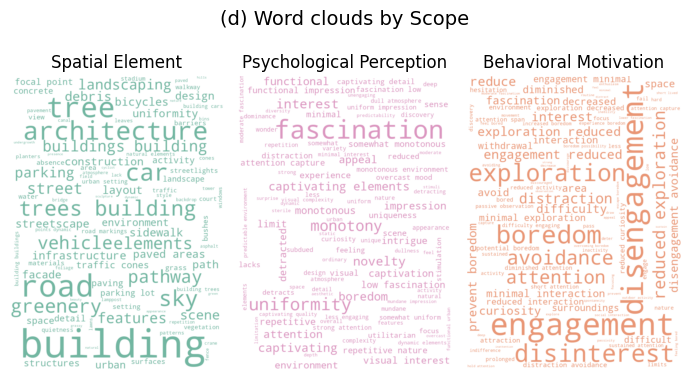

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# 创建示例数据
data = pd.read_csv("./spatial_analysis_results/reason_fascination_relationships_3.csv")
data = data[data['relation_type'] == 'negative']  # 只保留正向关系

# 为每个类别定义停用词
#fascination
category_stopwords = {
    'spatial_element': set(['']),  # 空间元素中要去除的词
    'behavioral_motivation': set(['limited', 'lack', 'limit']),  # 行为动机中要去除的词
    'psychological_perception': set(['lack', 'engagement', 'limited'])  # 心理感知中要去除的词
}
##being away
# category_stopwords = {
#     'spatial_element': set(['']),  # 空间元素中要去除的词
#     'behavioral_motivation': set(['presence', 'suggest', 'indicate']),  # 行为动机中要去除的词
#     'psychological_perception': set(['lack', 'feeling', 'sense', 'escape', 'limited'])  # 心理感知中要去除的词
# }

# ##coherence
# category_stopwords = {
#     'spatial_element': set(['']),  # 空间元素中要去除的词
#     'behavioral_motivation': set(['create', 'area','space','creates']),  # 行为动机中要去除的词
#     'psychological_perception': set(['lack'])  # 心理感知中要去除的词
# }

# ##coherence
# category_stopwords = {
#     'spatial_element': set(['']),  # 空间元素中要去除的词
#     'behavioral_motivation': set(['']),  # 行为动机中要去除的词
#     'psychological_perception': set(['feeling', 'sense'])  # 心理感知中要去除的词
# }


# 创建图形和子图
fig, axes = plt.subplots(1, 3, figsize=(7, 4))
fig.suptitle('(d) Word clouds by Scope', fontsize=14)

# 设置颜色
colors = ['#72B6A1', '#DB96C0','#E99675',]

# 为每个类别生成词云
for idx, (category, words) in enumerate(data.items()):
    if idx < 3:
        # 将列表中的词转换为适合词云的文本格式
        text = ' '.join(words) + ' ' + ' '.join(words)  # 重复文本以增加词频

        # 使用该类别的特定停用词
        stopwords = STOPWORDS.union(category_stopwords[category])
        
        # 创建词云
        wordcloud = WordCloud(
            width=800,
            height=1100,
            background_color='white',
            max_words=100,
            color_func=lambda *args, **kwargs: colors[idx],  # 使用指定颜色
            stopwords=stopwords,
            random_state=42
        ).generate(text)
        
        # 显示词云
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(category.replace('_', ' ').title())  # 标题也使用相应颜色

# 调整布局
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./figure/scope_wordclouds.png', bbox_inches='tight', dpi=300)
plt.show()